<a href="https://colab.research.google.com/github/yashgupta-7/legendre-forecasters/blob/main/lmu/Legendre_Memory_Unit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialisation

In [ ]:
!pip install nengolib


     |████████████████████████████████| 122kB 18.0MB/s 
     |████████████████████████████████| 378kB 31.0MB/s 


# LMU

In [ ]:
import torch
import torch.nn as nn
from sympy.matrices import Matrix, eye, zeros, ones, diag, GramSchmidt
import numpy as np
from functools import partial
import torch.nn.functional as F
import math

from nengolib.signal import Identity, cont2discrete
from nengolib.synapses import LegendreDelay
from functools import partial

def lecun_uniform(tensor):
    fan_in = nn.init._calculate_correct_fan(tensor, 'fan_in')
    nn.init.uniform_(tensor, -math.sqrt(3 / fan_in), math.sqrt(3 / fan_in))
    
class LegendreMemoryUnitCell(nn.Module):
  def __init__(self, input_dim, units , order, theta,
                 input_encoders_initializer=lecun_uniform,
                 hidden_encoders_initializer=lecun_uniform,
                 memory_encoders_initializer=partial(torch.nn.init.constant_, val=0),
                 input_kernel_initializer=torch.nn.init.xavier_normal_,
                 hidden_kernel_initializer=torch.nn.init.xavier_normal_,
                 memory_kernel_initializer=torch.nn.init.xavier_normal_):
    super(LegendreMemoryUnitCell, self).__init__()

    self.order = order
    self.theta = theta
    self.units = units
    

    realizer = Identity()
    self._realizer_result = realizer(LegendreDelay(theta=theta, order=self.order))

    self._ss = cont2discrete(self._realizer_result.realization, dt=1., method='zoh')

    self._A = self._ss.A - np.eye(order)
    self._B = self._ss.B
    self._C = self._ss.C

    self.AT = nn.Parameter(torch.Tensor(self._A), requires_grad=False)
    self.BT = nn.Parameter(torch.Tensor(self._B), requires_grad=False)


    self.encoder_input = nn.Parameter(torch.Tensor(1,input_dim), requires_grad=True)
    self.encoder_hidden = nn.Parameter(torch.Tensor(1,self.units), requires_grad=True)
    self.encoder_memory = nn.Parameter(torch.Tensor(1,self.order ), requires_grad=True)
    self.kernel_input = nn.Parameter(torch.Tensor(self.units, input_dim), requires_grad=True)
    self.kernel_hidden = nn.Parameter(torch.Tensor(self.units, self.units), requires_grad=True)
    self.kernel_memory = nn.Parameter(torch.Tensor(self.units, self.order), requires_grad=True)
    

    input_encoders_initializer(self.encoder_input)
    hidden_encoders_initializer(self.encoder_hidden)
    memory_encoders_initializer(self.encoder_memory)
    input_kernel_initializer(self.kernel_input)
    hidden_kernel_initializer(self.kernel_hidden)
    memory_kernel_initializer(self.kernel_memory)

  def EulerOdeSolver(self):
    A_hat = (self.step_delta_t/self.theta)*self.AT + torch.eye(self.order,self.d_order_ode)
    B_hat = (self.step_delta_t/self.theta)*self.BT

    return A_hat, B_hat

  def forward(self, xt, states):
    ht, mt = states
    
    ut = F.linear(xt, self.encoder_input) + F.linear(ht, self.encoder_hidden) + F.linear(mt, self.encoder_memory)
    
    mt = mt + F.linear(mt, self.AT) + F.linear(ut, self.BT)
    
    ht = nn.Tanh()(F.linear(xt, self.kernel_input) + F.linear(ht, self.kernel_hidden) + F.linear(mt, self.kernel_memory))

    return ht, (ht, mt)

class LegendreMemoryUnit(nn.Module):
  def __init__(self, input_dim, units , order, theta):
    super(LegendreMemoryUnit, self).__init__()

    self.units = units
    self.order = order

    self.lmucell = LegendreMemoryUnitCell(input_dim, units , order, theta)

  def forward(self, xt):
    outputs = []
    
    h0 = torch.zeros(xt.size(0),self.units).cuda()
    m0 = torch.zeros(xt.size(0),self.order).cuda()
    states = (h0,m0)
    for i in range(xt.size(1)):
      out, states = self.lmucell(xt[:,i,:], states)
      outputs += [out]
    return torch.stack(outputs).permute(1,0,2), states
    # return torch.stack(outputs).permute(1,0,2), states


# Test LMU output

In [ ]:
x = torch.rand(64,5000,1).cuda()
h0 = torch.rand(64,49).cuda()
m0 = torch.rand(64,4).cuda()
model = LegendreMemoryUnit(1,49,4,4)
model=model.to(torch.device("cuda:0"))
for name in model.parameters():
      # print(name,end=' ')
      print(name.device)
        # print(param.data)
res, _ = model(x.to(torch.device("cuda:0")))
print(res.shape)

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
torch.Size([64, 5000, 49])


# Models LSTM - LMU

In [ ]:
class LMUModel(nn.Module):
  def __init__(self):
    super(LMUModel, self).__init__()
    self.LMU = LegendreMemoryUnit(1,64,4,4)
    self.dense = nn.Linear(64,1)

  def forward(self,x):
    x, _ = self.LMU(x)
    x = self.dense(x)

    return x

model_lstm = LMUModel()

print("Nombre de paramètres : ", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))
print()


Nombre de paramètres :  4550



In [ ]:
class LSTMModel(nn.Module):
  def __init__(self):
    super(LSTMModel, self).__init__()
    self.LSTM = nn.LSTM(1,64,1,batch_first=True)
    self.dense = nn.Linear(64,1)

  def forward(self,x):
    x, _ = self.LSTM(x)
    x = self.dense(x)

    return x
    
model_lstm = LSTMModel()

print("Nombre de paramètres : ", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))
print()


Nombre de paramètres :  17217



# MackeyGlass Datas

Took from official LMU (tensorflow) repo

(128, 5115, 1)^^
100
(128, 5015, 1)**
(128, 5000, 1)##
(128, 5000, 1)!!
(64, 5000, 1) (64, 5000, 1)


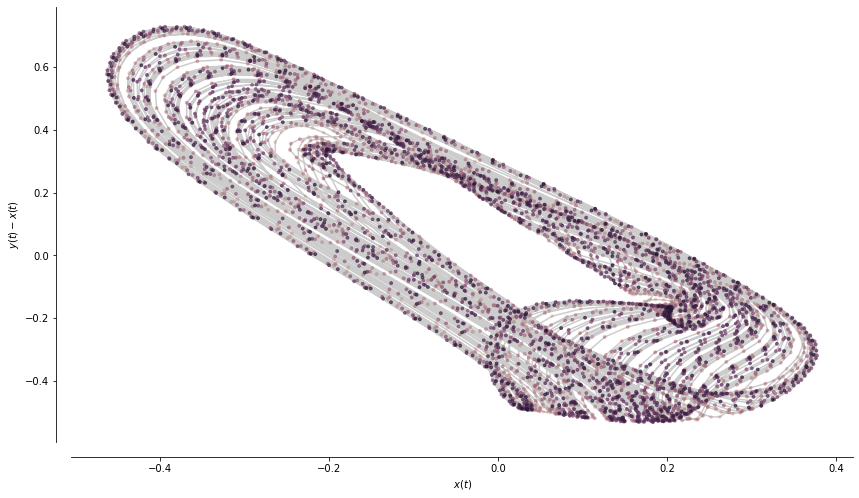

In [ ]:
import collections 
import matplotlib.pyplot as plt

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, RNN
from keras.initializers import RandomUniform
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from torchsummary import summary

def mackey_glass(sample_len=1000, tau=17, delta_t=10, seed=None, n_samples=1):
    # Adapted from https://github.com/mila-iqia/summerschool2015/blob/master/rnn_tutorial/synthetic.py
    '''
    mackey_glass(sample_len=1000, tau=17, seed = None, n_samples = 1) -> input
    Generate the Mackey Glass time-series. Parameters are:
        - sample_len: length of the time-series in timesteps. Default is 1000.
        - tau: delay of the MG - system. Commonly used values are tau=17 (mild 
          chaos) and tau=30 (moderate chaos). Default is 17.
        - seed: to seed the random generator, can be used to generate the same
          timeseries at each invocation.
        - n_samples : number of samples to generate
    '''
    history_len = tau * delta_t 
    # Initial conditions for the history of the system
    timeseries = 1.2
    
    if seed is not None:
        np.random.seed(seed)

    samples = []

    for _ in range(n_samples):
        history = collections.deque(1.2 * np.ones(history_len) + 0.2 * \
                                    (np.random.rand(history_len) - 0.5))
        # Preallocate the array for the time-series
        inp = np.zeros((sample_len,1))
        
        for timestep in range(sample_len):
            for _ in range(delta_t):
                xtau = history.popleft()
                history.append(timeseries)
                timeseries = history[-1] + (0.2 * xtau / (1.0 + xtau ** 10) - \
                             0.1 * history[-1]) / delta_t
            inp[timestep] = timeseries
        
        # Squash timeseries through tanh
        inp = np.tanh(inp - 1)
        samples.append(inp)
    return samples

def generate_data(n_batches, length, split=0.5, seed=0,
                  predict_length=15, tau=17, washout=100, delta_t=1,
                  center=True):
    X = np.asarray(mackey_glass(
        sample_len=length+predict_length+washout, tau=tau,
        seed=seed, n_samples=n_batches))
    print(X.shape,end='^^\n')
    print(washout)
    X = X[:, washout:, :]
    print(X.shape,end='**\n')
    cutoff = int(split*n_batches)
    if center:
        X -= np.mean(X)  # global mean over all batches, approx -0.066
    Y = X[:, :-predict_length, :]
    print(Y.shape,end='##\n')
    X = X[:, predict_length:, :]
    print(X.shape,end='!!\n')
    assert X.shape == Y.shape
    return ((X[:cutoff], Y[:cutoff]),
            (X[cutoff:], Y[cutoff:]))

(train_X, train_Y), (test_X, test_Y) = generate_data(128, 5000)
print(train_X.shape, test_X.shape)

def cool_plot(X, Y, title=""):
    plt.figure(figsize=(14, 8))
    plt.title(title)
    plt.scatter(X[:, 0], Y[:, 0] - X[:, 0], s=8, alpha=0.7,
                c=np.arange(X.shape[0]), cmap=sns.cubehelix_palette(as_cmap=True))
    plt.plot(X[:, 0], Y[:, 0] - X[:, 0], c='black', alpha=0.2)
    plt.xlabel("$x(t)$")
    plt.ylabel("$y(t) - x(t)$")
    sns.despine(offset=15)
    
    plt.show()

cool_plot(train_X[0], train_Y[0])

# plt.plot(train_X[0][0:100])
# plt.plot(train_Y[0][0:100])
# plt.show()



# Utils

In [ ]:
def train(model, epochs, dataset, dataset_valid = None):
  for e in tqdm(range(epochs)):
      model.train()
      running_loss = 0
      # with (len(dataset)) as bar:
      for i, (X, y) in enumerate(dataset):
          optimizer.zero_grad()
          
          output = model(X.cuda())

          loss_ll = criterion(output, y.cuda())
          
          loss_ll.backward()
          
          optimizer.step()
          
          running_loss += loss_ll.item()
      model.eval()
      running_loss = 0
      outs = []
      t1,t2=None,None
      for i, (X, y) in enumerate(dataset_valid):
          optimizer.zero_grad()
          
          output = model(X.cuda())
   
          loss_ll = criterion(output, y.cuda())
          if i==0:
            t1=output.detach().cpu().numpy()[0]
            t2=y.detach().cpu().numpy()[0]
          running_loss += loss_ll.item()
          
          outs.append(output)
          # bar.update(1)
      plt.plot(t1)
      plt.plot(t2)
      plt.show()
      print("Epoch {} - Training val loss: {}".format(e, running_loss/len(dataset_valid)))

# Test LMU vs LSTM on MackeyGlass

  0%|          | 0/100 [00:00<?, ?it/s]

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


Nombre de paramètres :  4550





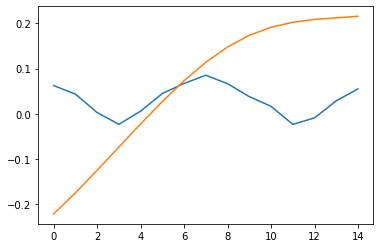

  1%|          | 1/100 [00:08<13:49,  8.38s/it]

Epoch 0 - Training val loss: 0.043255992233753204


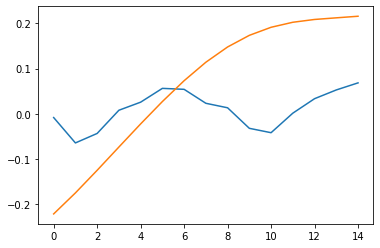

  2%|▏         | 2/100 [00:16<13:45,  8.42s/it]

Epoch 1 - Training val loss: 0.039336579851806164


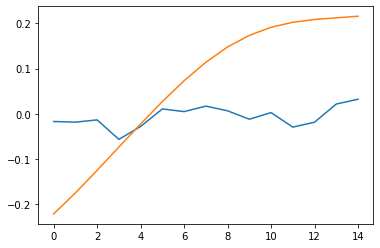

  3%|▎         | 3/100 [00:25<13:33,  8.38s/it]

Epoch 2 - Training val loss: 0.03592369519174099


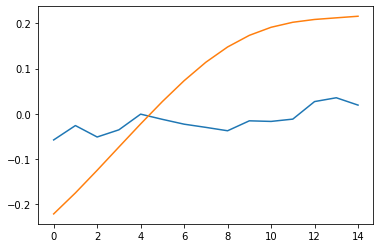

  4%|▍         | 4/100 [00:33<13:28,  8.42s/it]

Epoch 3 - Training val loss: 0.03240502253174782


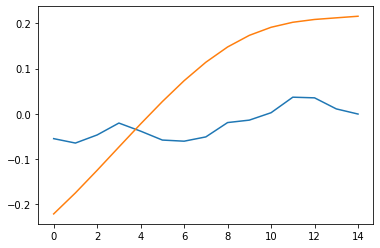

  5%|▌         | 5/100 [00:42<13:18,  8.41s/it]

Epoch 4 - Training val loss: 0.02711031073704362


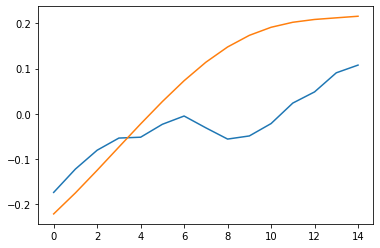

  6%|▌         | 6/100 [00:50<13:13,  8.44s/it]

Epoch 5 - Training val loss: 0.01837733155116439


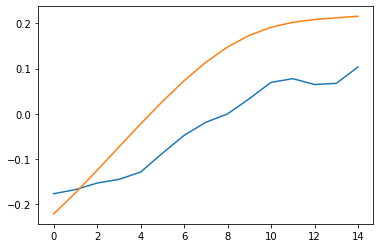

  7%|▋         | 7/100 [00:59<13:04,  8.44s/it]

Epoch 6 - Training val loss: 0.008333724457770586


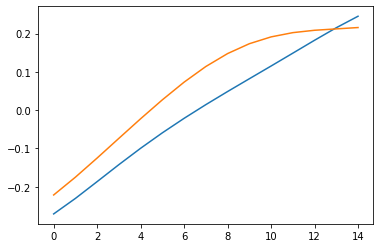

  8%|▊         | 8/100 [01:07<12:57,  8.46s/it]

Epoch 7 - Training val loss: 0.004200587631203234


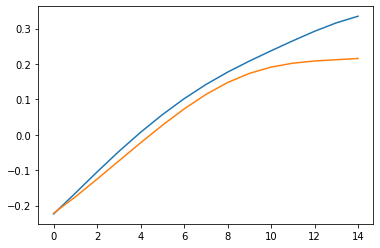

  9%|▉         | 9/100 [01:16<12:50,  8.47s/it]

Epoch 8 - Training val loss: 0.0076817781664431095


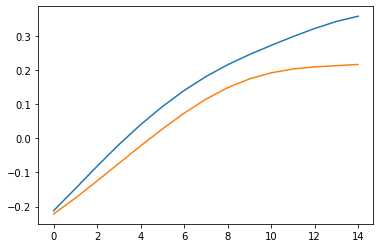

 10%|█         | 10/100 [01:24<12:38,  8.43s/it]

Epoch 9 - Training val loss: 0.01086734957061708


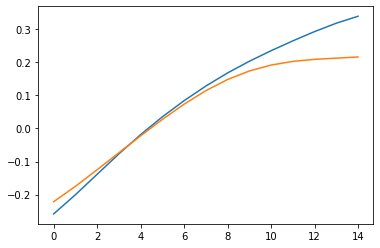

 11%|█         | 11/100 [01:32<12:26,  8.39s/it]

Epoch 10 - Training val loss: 0.007801403407938778


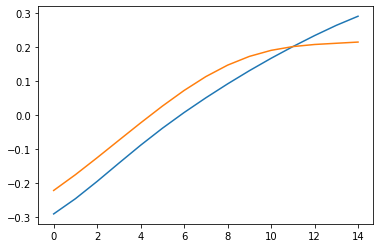

 12%|█▏        | 12/100 [01:41<12:18,  8.39s/it]

Epoch 11 - Training val loss: 0.005674510262906551


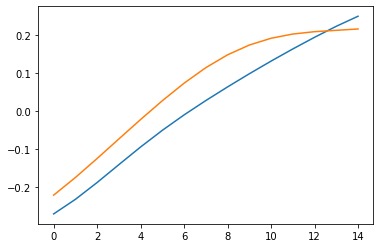

 13%|█▎        | 13/100 [01:49<12:11,  8.41s/it]

Epoch 12 - Training val loss: 0.004606151836924255


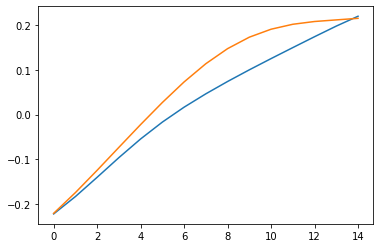

 14%|█▍        | 14/100 [01:58<12:07,  8.46s/it]

Epoch 13 - Training val loss: 0.003640787152107805


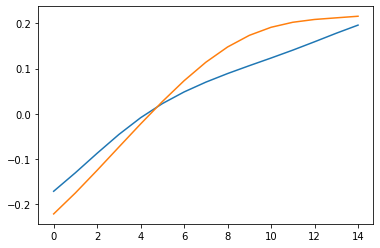

 15%|█▌        | 15/100 [02:06<11:57,  8.44s/it]

Epoch 14 - Training val loss: 0.004573436104692519


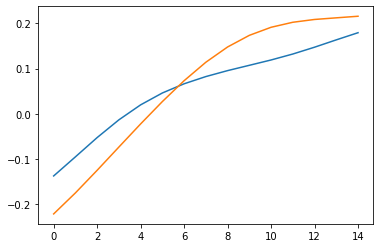

 16%|█▌        | 16/100 [02:14<11:48,  8.44s/it]

Epoch 15 - Training val loss: 0.006249995552934706


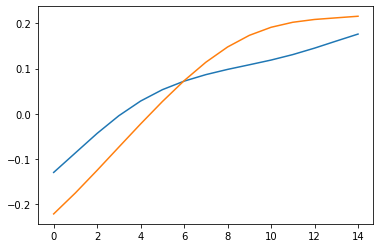

 17%|█▋        | 17/100 [02:23<11:38,  8.41s/it]

Epoch 16 - Training val loss: 0.006620621774345636


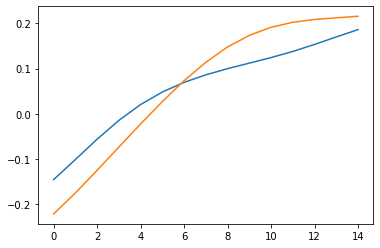

 18%|█▊        | 18/100 [02:31<11:27,  8.39s/it]

Epoch 17 - Training val loss: 0.005495376302860677


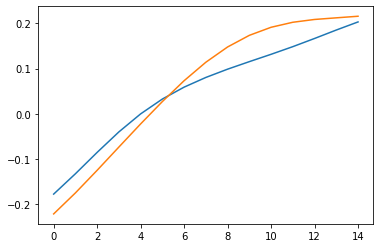

 19%|█▉        | 19/100 [02:39<11:19,  8.39s/it]

Epoch 18 - Training val loss: 0.004003620008006692


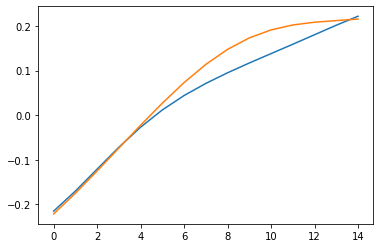

 20%|██        | 20/100 [02:48<11:13,  8.42s/it]

Epoch 19 - Training val loss: 0.0033012631465680897


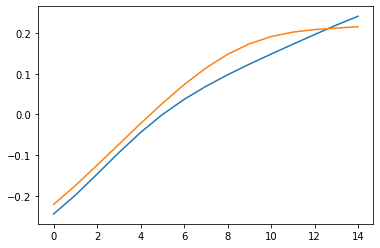

 21%|██        | 21/100 [02:56<11:05,  8.42s/it]

Epoch 20 - Training val loss: 0.003444359463173896


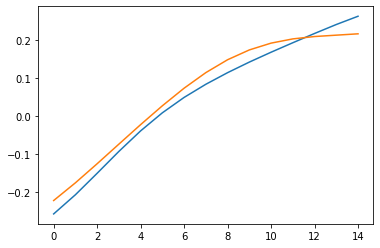

 22%|██▏       | 22/100 [03:05<10:54,  8.40s/it]

Epoch 21 - Training val loss: 0.003687704389449209


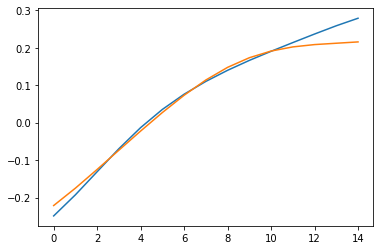

 23%|██▎       | 23/100 [03:13<10:48,  8.42s/it]

Epoch 22 - Training val loss: 0.003972162608988583


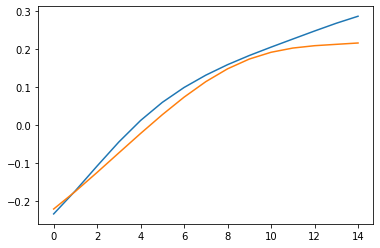

 24%|██▍       | 24/100 [03:22<10:40,  8.43s/it]

Epoch 23 - Training val loss: 0.004331964650191367


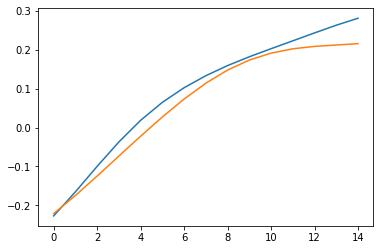

 25%|██▌       | 25/100 [03:30<10:36,  8.49s/it]

Epoch 24 - Training val loss: 0.004146310733631253


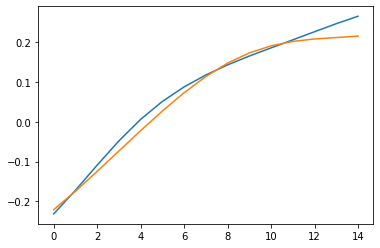

 26%|██▌       | 26/100 [03:39<10:24,  8.43s/it]

Epoch 25 - Training val loss: 0.0034304107539355755


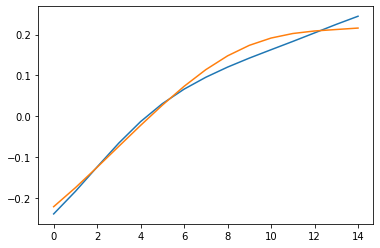

 27%|██▋       | 27/100 [03:47<10:12,  8.39s/it]

Epoch 26 - Training val loss: 0.0029220853466540575


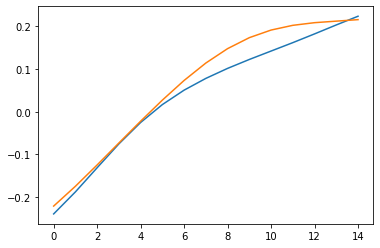

 28%|██▊       | 28/100 [03:55<10:05,  8.41s/it]

Epoch 27 - Training val loss: 0.0028882076730951667


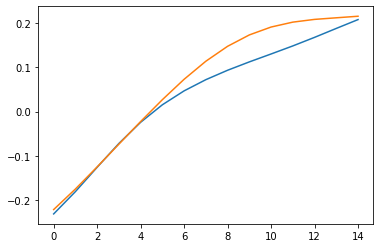

 29%|██▉       | 29/100 [04:04<09:56,  8.39s/it]

Epoch 28 - Training val loss: 0.002990025153849274


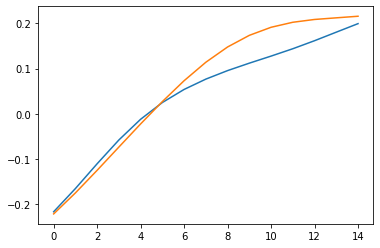

 30%|███       | 30/100 [04:12<09:49,  8.42s/it]

Epoch 29 - Training val loss: 0.0030554799595847726


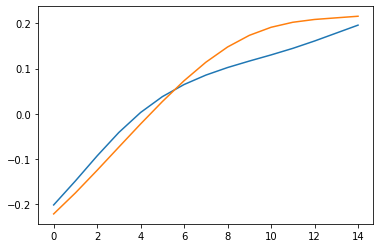

 31%|███       | 31/100 [04:21<09:39,  8.39s/it]

Epoch 30 - Training val loss: 0.00315107119968161


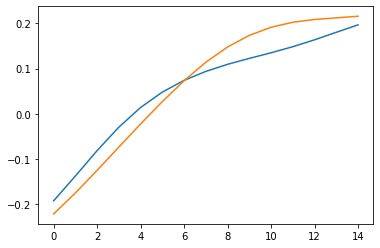

 32%|███▏      | 32/100 [04:29<09:28,  8.37s/it]

Epoch 31 - Training val loss: 0.00322036468423903


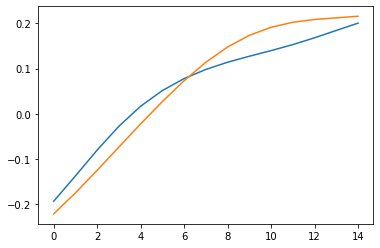

 33%|███▎      | 33/100 [04:37<09:20,  8.37s/it]

Epoch 32 - Training val loss: 0.0031048314413055778


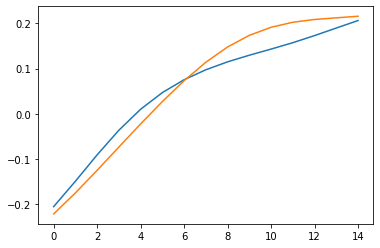

 34%|███▍      | 34/100 [04:46<09:11,  8.36s/it]

Epoch 33 - Training val loss: 0.0028084908262826502


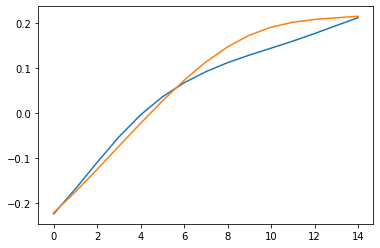

 35%|███▌      | 35/100 [04:54<09:06,  8.41s/it]

Epoch 34 - Training val loss: 0.0025491585838608444


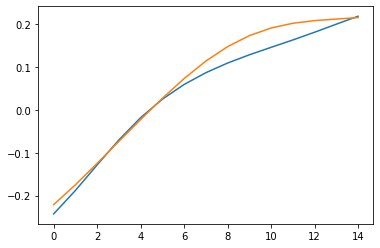

 36%|███▌      | 36/100 [05:02<08:56,  8.38s/it]

Epoch 35 - Training val loss: 0.002495433553121984


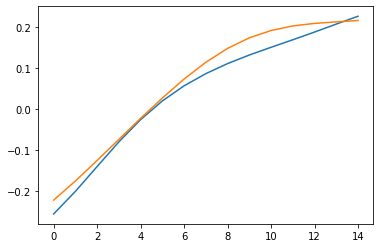

 37%|███▋      | 37/100 [05:11<08:46,  8.36s/it]

Epoch 36 - Training val loss: 0.0025475402362644672


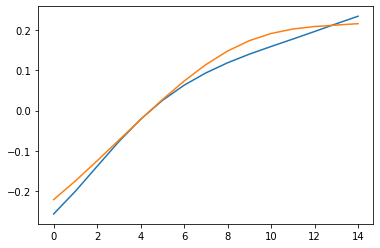

 38%|███▊      | 38/100 [05:19<08:36,  8.34s/it]

Epoch 37 - Training val loss: 0.0025520710623823106


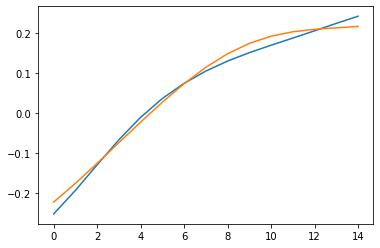

 39%|███▉      | 39/100 [05:27<08:27,  8.31s/it]

Epoch 38 - Training val loss: 0.0025462702033109963


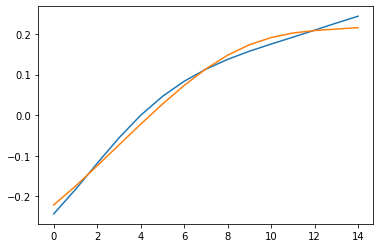

 40%|████      | 40/100 [05:35<08:18,  8.30s/it]

Epoch 39 - Training val loss: 0.002548832620959729


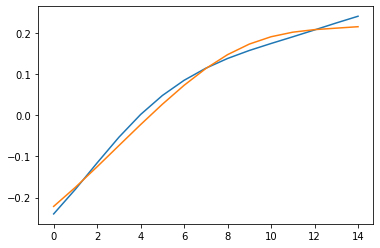

 41%|████      | 41/100 [05:44<08:10,  8.31s/it]

Epoch 40 - Training val loss: 0.002458828210365027


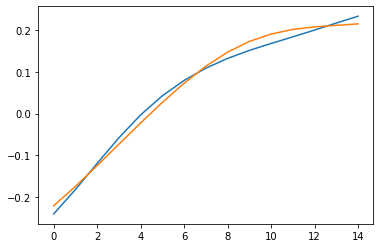

 42%|████▏     | 42/100 [05:52<08:04,  8.35s/it]

Epoch 41 - Training val loss: 0.0022876403527334332


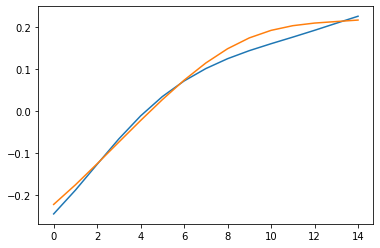

 43%|████▎     | 43/100 [06:01<07:55,  8.34s/it]

Epoch 42 - Training val loss: 0.002172814740333706


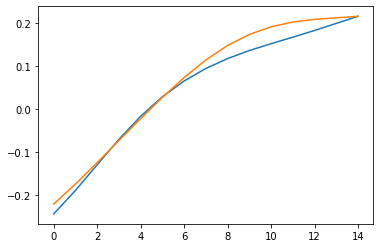

 44%|████▍     | 44/100 [06:09<07:50,  8.40s/it]

Epoch 43 - Training val loss: 0.0021555261919274926


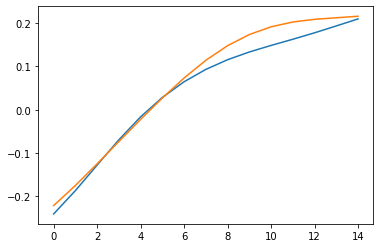

 45%|████▌     | 45/100 [06:18<07:47,  8.50s/it]

Epoch 44 - Training val loss: 0.0021581510663963854


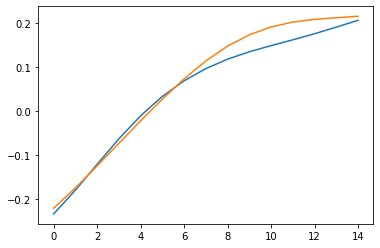

 46%|████▌     | 46/100 [06:27<07:42,  8.56s/it]

Epoch 45 - Training val loss: 0.0021420661360025406


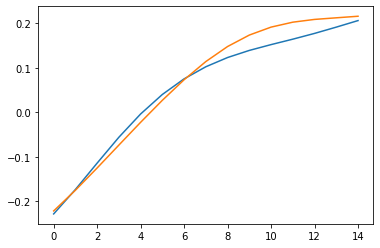

 47%|████▋     | 47/100 [06:35<07:35,  8.60s/it]

Epoch 46 - Training val loss: 0.0021262046648189425


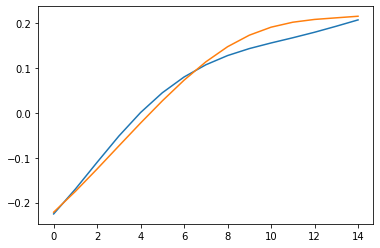

 48%|████▊     | 48/100 [06:44<07:27,  8.61s/it]

Epoch 47 - Training val loss: 0.002101444872096181


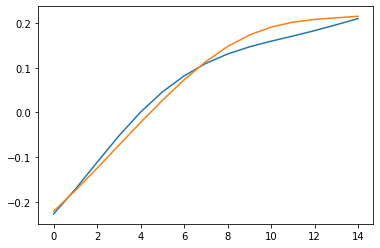

 49%|████▉     | 49/100 [06:53<07:21,  8.65s/it]

Epoch 48 - Training val loss: 0.002036924532148987


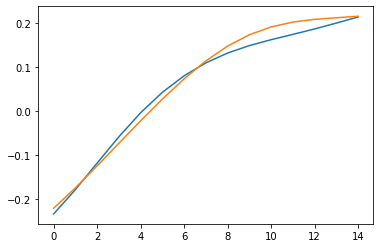

 50%|█████     | 50/100 [07:01<07:09,  8.58s/it]

Epoch 49 - Training val loss: 0.0019476356683298945


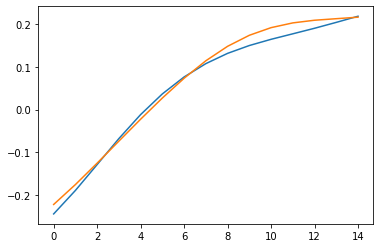

 51%|█████     | 51/100 [07:09<06:57,  8.53s/it]

Epoch 50 - Training val loss: 0.0018871726642828435


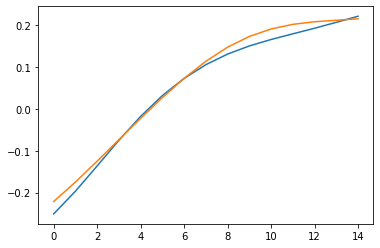

 52%|█████▏    | 52/100 [07:18<06:47,  8.49s/it]

Epoch 51 - Training val loss: 0.001870320993475616


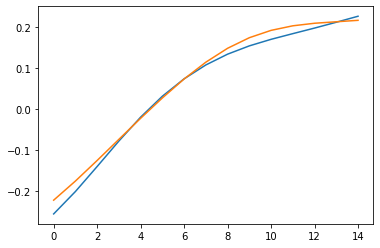

 53%|█████▎    | 53/100 [07:26<06:38,  8.48s/it]

Epoch 52 - Training val loss: 0.0018582400807645172


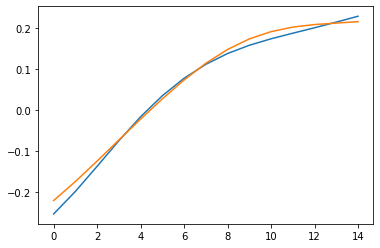

 54%|█████▍    | 54/100 [07:35<06:31,  8.52s/it]

Epoch 53 - Training val loss: 0.0018296249909326434


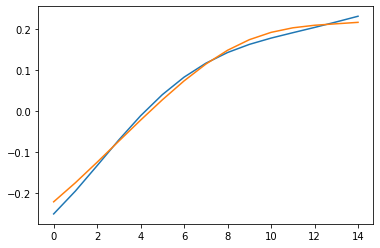

 55%|█████▌    | 55/100 [07:43<06:23,  8.52s/it]

Epoch 54 - Training val loss: 0.0017973693029489368


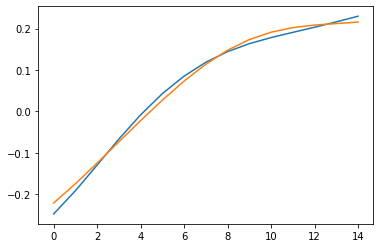

 56%|█████▌    | 56/100 [07:52<06:14,  8.51s/it]

Epoch 55 - Training val loss: 0.0017586113244760782


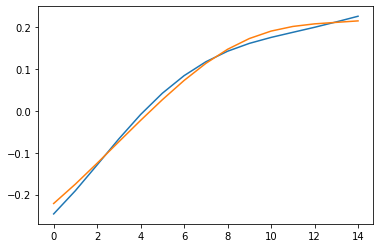

 57%|█████▋    | 57/100 [08:00<06:04,  8.47s/it]

Epoch 56 - Training val loss: 0.0017020033264998347


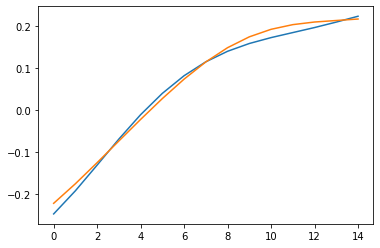

 58%|█████▊    | 58/100 [08:09<05:56,  8.49s/it]

Epoch 57 - Training val loss: 0.0016452674171887338


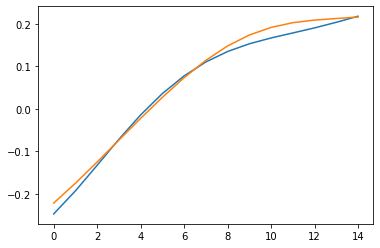

 59%|█████▉    | 59/100 [08:18<05:51,  8.57s/it]

Epoch 58 - Training val loss: 0.0016120009240694344


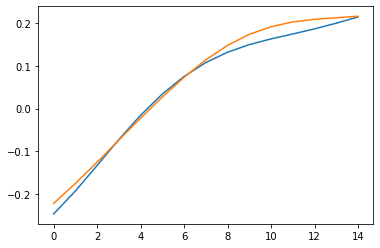

 60%|██████    | 60/100 [08:26<05:41,  8.53s/it]

Epoch 59 - Training val loss: 0.0015941627498250455


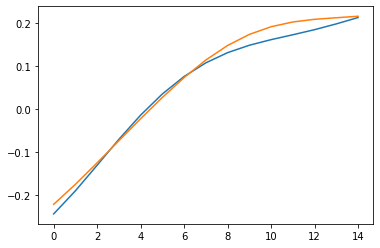

 61%|██████    | 61/100 [08:35<05:32,  8.53s/it]

Epoch 60 - Training val loss: 0.0015699900686740875


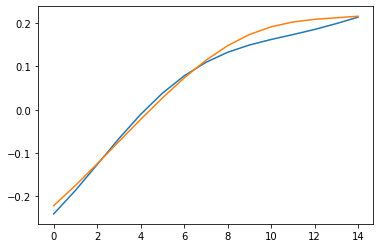

 62%|██████▏   | 62/100 [08:43<05:24,  8.53s/it]

Epoch 61 - Training val loss: 0.0015358439122792333


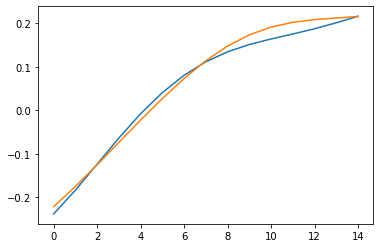

 63%|██████▎   | 63/100 [08:52<05:16,  8.55s/it]

Epoch 62 - Training val loss: 0.0014987722679506987


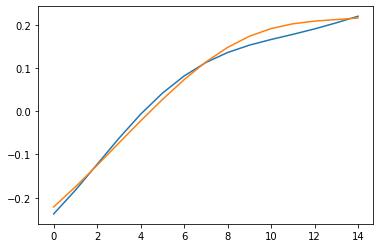

 64%|██████▍   | 64/100 [09:00<05:07,  8.53s/it]

Epoch 63 - Training val loss: 0.0014591810468118638


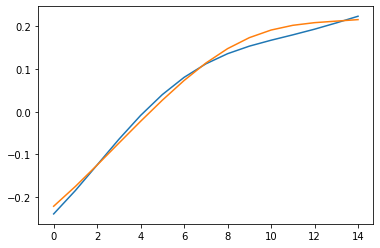

 65%|██████▌   | 65/100 [09:09<04:59,  8.54s/it]

Epoch 64 - Training val loss: 0.0014181109727360308


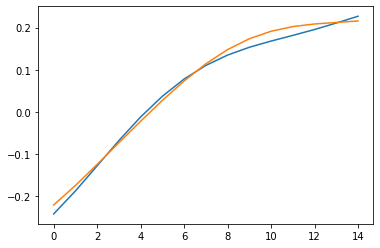

 66%|██████▌   | 66/100 [09:17<04:50,  8.55s/it]

Epoch 65 - Training val loss: 0.0013851162511855364


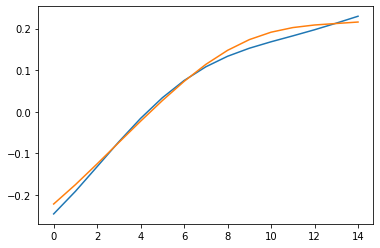

 67%|██████▋   | 67/100 [09:26<04:43,  8.60s/it]

Epoch 66 - Training val loss: 0.0013633189373649657


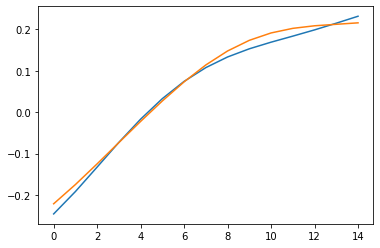

 68%|██████▊   | 68/100 [09:34<04:32,  8.52s/it]

Epoch 67 - Training val loss: 0.0013404232449829578


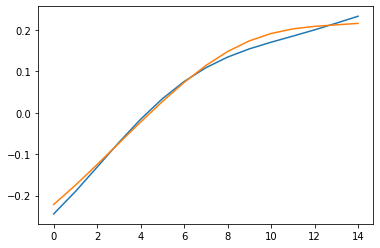

 69%|██████▉   | 69/100 [09:43<04:22,  8.48s/it]

Epoch 68 - Training val loss: 0.001307917438680306


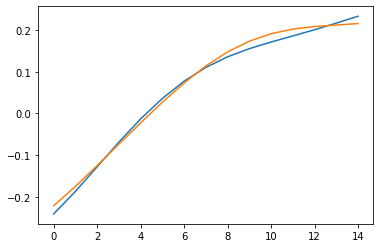

 70%|███████   | 70/100 [09:51<04:12,  8.42s/it]

Epoch 69 - Training val loss: 0.00127215136308223


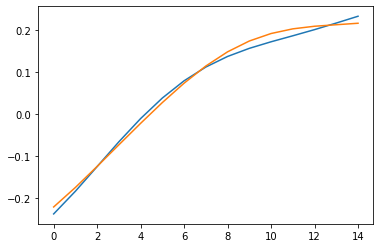

 71%|███████   | 71/100 [09:59<04:04,  8.42s/it]

Epoch 70 - Training val loss: 0.001239160425029695


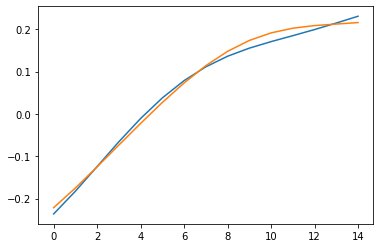

 72%|███████▏  | 72/100 [10:08<03:55,  8.40s/it]

Epoch 71 - Training val loss: 0.0012085639464203268


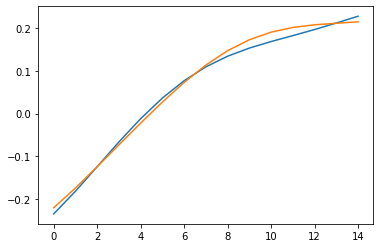

 73%|███████▎  | 73/100 [10:16<03:48,  8.46s/it]

Epoch 72 - Training val loss: 0.001181686413474381


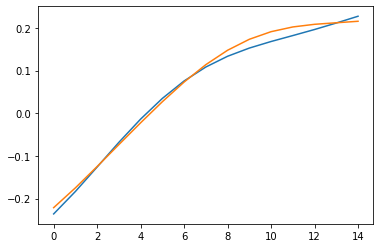

 74%|███████▍  | 74/100 [10:25<03:40,  8.46s/it]

Epoch 73 - Training val loss: 0.0011587728513404727


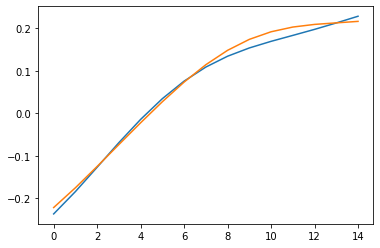

 75%|███████▌  | 75/100 [10:33<03:31,  8.47s/it]

Epoch 74 - Training val loss: 0.0011337704781908542


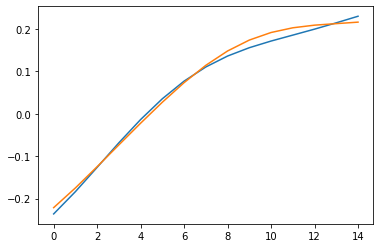

 76%|███████▌  | 76/100 [10:42<03:21,  8.42s/it]

Epoch 75 - Training val loss: 0.001103756861994043


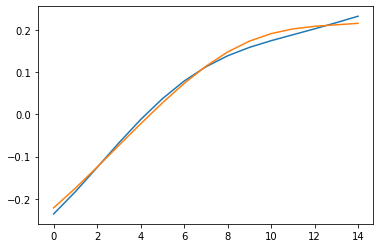

 77%|███████▋  | 77/100 [10:50<03:13,  8.42s/it]

Epoch 76 - Training val loss: 0.0010749801294878125


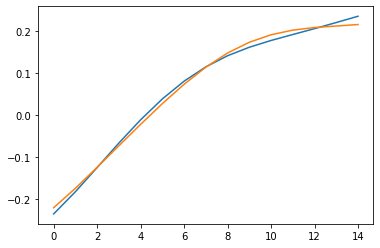

 78%|███████▊  | 78/100 [10:58<03:04,  8.39s/it]

Epoch 77 - Training val loss: 0.0010519384522922337


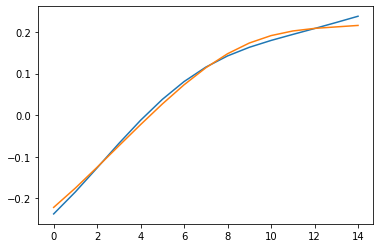

 79%|███████▉  | 79/100 [11:07<02:56,  8.40s/it]

Epoch 78 - Training val loss: 0.0010315979889128357


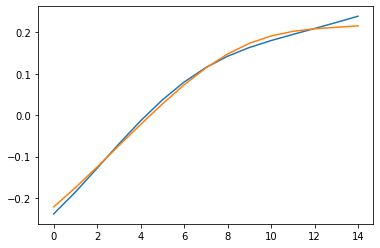

 80%|████████  | 80/100 [11:15<02:47,  8.37s/it]

Epoch 79 - Training val loss: 0.0010114779288414866


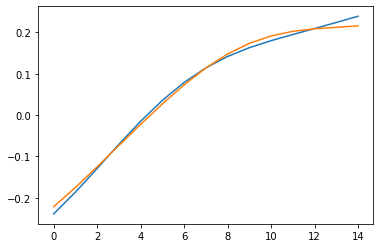

 81%|████████  | 81/100 [11:23<02:38,  8.35s/it]

Epoch 80 - Training val loss: 0.0009915130794979632


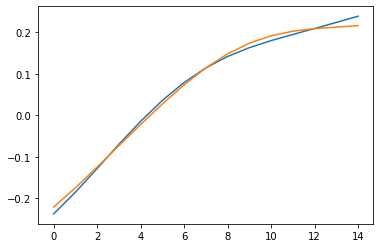

 82%|████████▏ | 82/100 [11:32<02:30,  8.36s/it]

Epoch 81 - Training val loss: 0.0009704117255751044


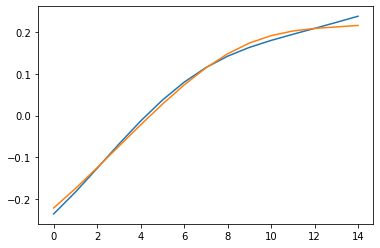

 83%|████████▎ | 83/100 [11:40<02:22,  8.39s/it]

Epoch 82 - Training val loss: 0.0009496330603724346


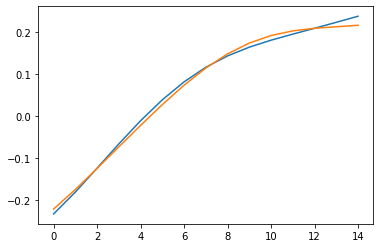

 84%|████████▍ | 84/100 [11:49<02:13,  8.36s/it]

Epoch 83 - Training val loss: 0.0009326689905719832


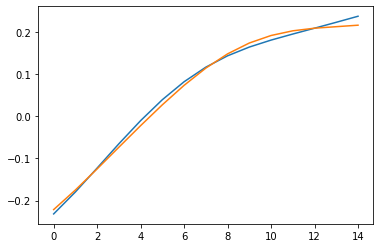

 85%|████████▌ | 85/100 [11:57<02:05,  8.35s/it]

Epoch 84 - Training val loss: 0.0009176210151053965


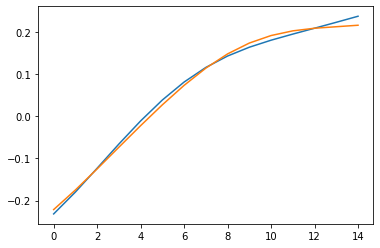

 86%|████████▌ | 86/100 [12:05<01:56,  8.34s/it]

Epoch 85 - Training val loss: 0.0009006858308566734


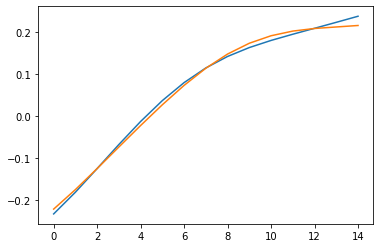

 87%|████████▋ | 87/100 [12:14<01:48,  8.34s/it]

Epoch 86 - Training val loss: 0.0008828621357679367


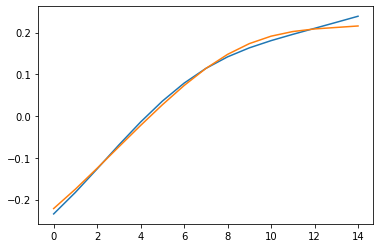

 88%|████████▊ | 88/100 [12:22<01:40,  8.34s/it]

Epoch 87 - Training val loss: 0.0008663219050504267


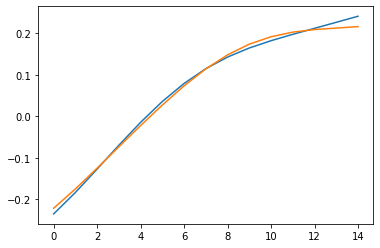

 89%|████████▉ | 89/100 [12:30<01:31,  8.31s/it]

Epoch 88 - Training val loss: 0.0008513395878253505


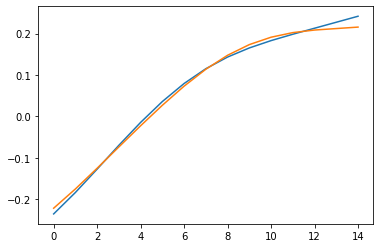

 90%|█████████ | 90/100 [12:38<01:23,  8.32s/it]

Epoch 89 - Training val loss: 0.0008379657519981265


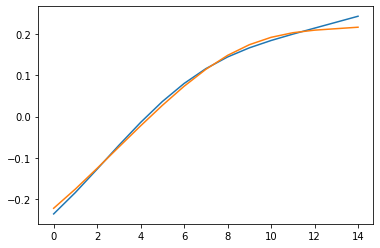

 91%|█████████ | 91/100 [12:47<01:15,  8.35s/it]

Epoch 90 - Training val loss: 0.0008246057841461152


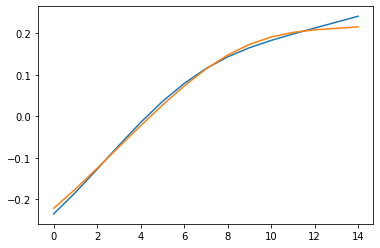

 92%|█████████▏| 92/100 [12:55<01:06,  8.33s/it]

Epoch 91 - Training val loss: 0.0008098921389319003


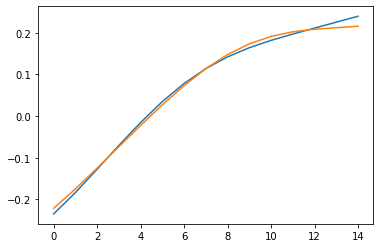

 93%|█████████▎| 93/100 [13:03<00:58,  8.32s/it]

Epoch 92 - Training val loss: 0.000796073378296569


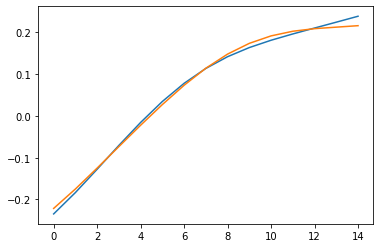

 94%|█████████▍| 94/100 [13:12<00:49,  8.32s/it]

Epoch 93 - Training val loss: 0.0007842551567591727


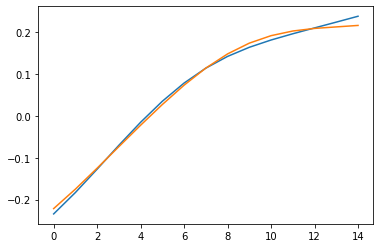

 95%|█████████▌| 95/100 [13:20<00:41,  8.29s/it]

Epoch 94 - Training val loss: 0.0007726718322373927


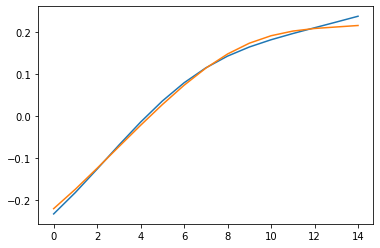

 96%|█████████▌| 96/100 [13:28<00:33,  8.28s/it]

Epoch 95 - Training val loss: 0.0007608347368659452


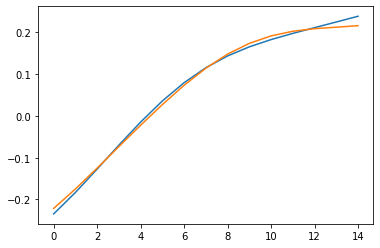

 97%|█████████▋| 97/100 [13:36<00:24,  8.26s/it]

Epoch 96 - Training val loss: 0.0007489819399779662


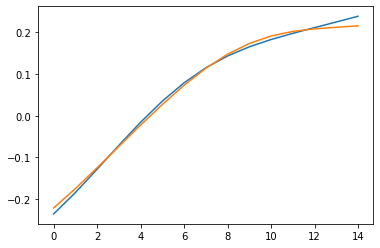

 98%|█████████▊| 98/100 [13:45<00:16,  8.32s/it]

Epoch 97 - Training val loss: 0.0007374921697191894


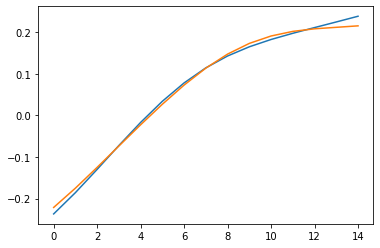

 99%|█████████▉| 99/100 [13:53<00:08,  8.30s/it]

Epoch 98 - Training val loss: 0.0007270632340805605


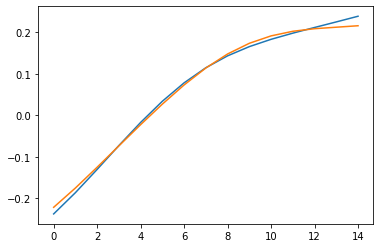

100%|██████████| 100/100 [14:02<00:00,  8.42s/it]

Epoch 99 - Training val loss: 0.0007166001450968906


In [ ]:
from tqdm import tqdm
import torch.utils.data as data



model = LMUModel().cuda()
for name in model.parameters():
      # print(name,end=' ')
      print(name.device)
print("\n\nNombre de paramètres : ", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("\n\n")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

dataset = torch.utils.data.TensorDataset(torch.Tensor(train_X).cuda(), torch.Tensor(train_Y).cuda())
dataset = data.DataLoader(dataset, batch_size=64, shuffle=True)

dataset_valid = torch.utils.data.TensorDataset(torch.Tensor(test_X).cuda(), torch.Tensor(test_Y).cuda())
dataset_valid = data.DataLoader(dataset_valid, batch_size=16, shuffle=False)

train(model, 100, dataset, dataset_valid)

  0%|          | 0/100 [00:00<?, ?it/s]



Nombre de paramètres :  17217





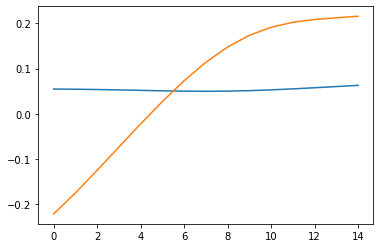

  1%|          | 1/100 [00:00<01:03,  1.56it/s]

Epoch 0 - Training val loss: 0.050055280327796936


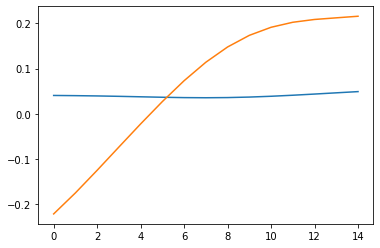

  2%|▏         | 2/100 [00:01<00:58,  1.68it/s]

Epoch 1 - Training val loss: 0.048367240466177464


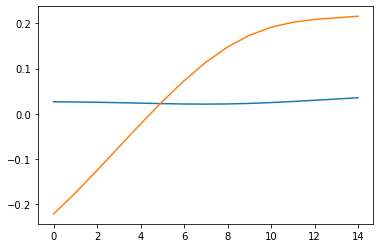

  3%|▎         | 3/100 [00:01<00:54,  1.79it/s]

Epoch 2 - Training val loss: 0.04707617126405239


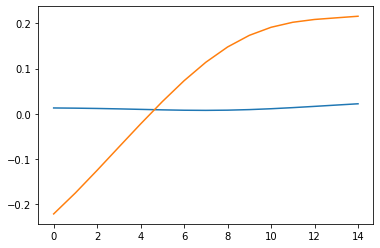

  4%|▍         | 4/100 [00:02<00:51,  1.88it/s]

Epoch 3 - Training val loss: 0.04617095738649368


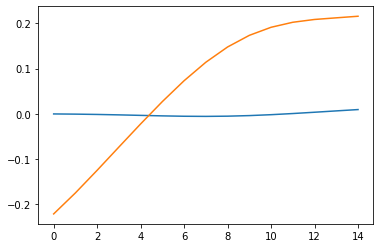

  5%|▌         | 5/100 [00:02<00:48,  1.95it/s]

Epoch 4 - Training val loss: 0.0456309774890542


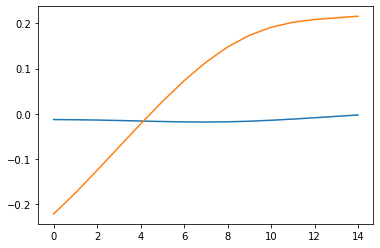

  6%|▌         | 6/100 [00:03<00:47,  2.00it/s]

Epoch 5 - Training val loss: 0.045417338609695435


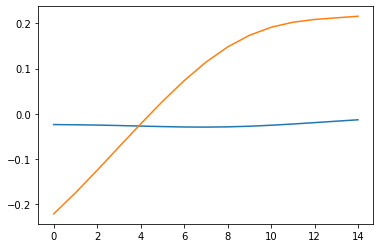

  7%|▋         | 7/100 [00:03<00:45,  2.03it/s]

Epoch 6 - Training val loss: 0.04545949585735798


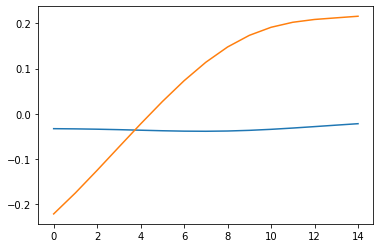

  8%|▊         | 8/100 [00:03<00:44,  2.06it/s]

Epoch 7 - Training val loss: 0.04564710333943367


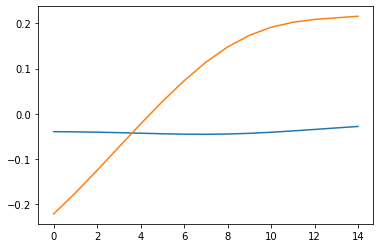

  9%|▉         | 9/100 [00:04<00:43,  2.08it/s]

Epoch 8 - Training val loss: 0.045850759372115135


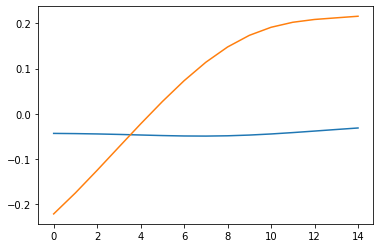

 10%|█         | 10/100 [00:04<00:43,  2.08it/s]

Epoch 9 - Training val loss: 0.04596989508718252


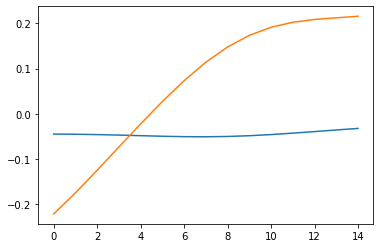

 11%|█         | 11/100 [00:05<00:42,  2.08it/s]

Epoch 10 - Training val loss: 0.04596283286809921


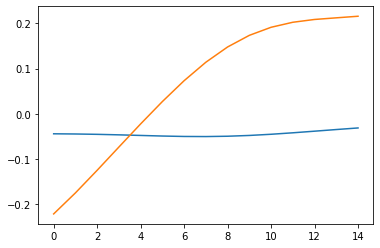

 12%|█▏        | 12/100 [00:05<00:42,  2.08it/s]

Epoch 11 - Training val loss: 0.045838963240385056


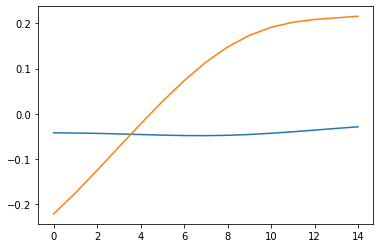

 13%|█▎        | 13/100 [00:06<00:42,  2.06it/s]

Epoch 12 - Training val loss: 0.045634631998836994


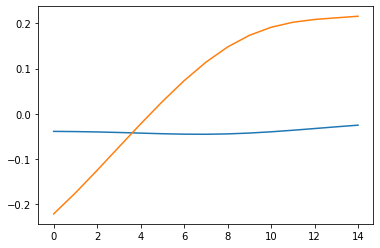

 14%|█▍        | 14/100 [00:06<00:42,  2.04it/s]

Epoch 13 - Training val loss: 0.04539247788488865


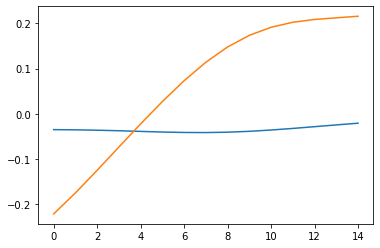

 15%|█▌        | 15/100 [00:07<00:41,  2.04it/s]

Epoch 14 - Training val loss: 0.045149358920753


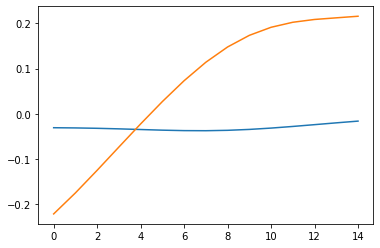

 16%|█▌        | 16/100 [00:07<00:41,  2.05it/s]

Epoch 15 - Training val loss: 0.04493114259094


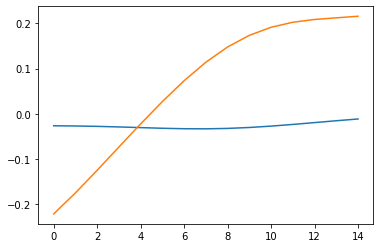

 17%|█▋        | 17/100 [00:08<00:40,  2.07it/s]

Epoch 16 - Training val loss: 0.0447517903521657


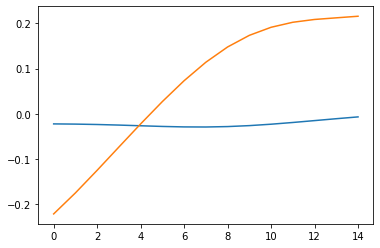

 18%|█▊        | 18/100 [00:08<00:39,  2.08it/s]

Epoch 17 - Training val loss: 0.04461473319679499


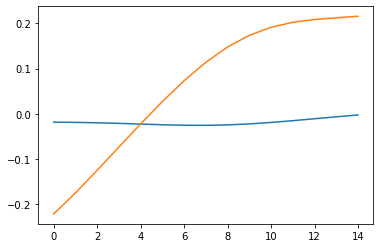

 19%|█▉        | 19/100 [00:09<00:38,  2.08it/s]

Epoch 18 - Training val loss: 0.04451537877321243


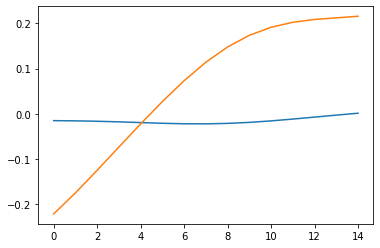

 20%|██        | 20/100 [00:09<00:38,  2.09it/s]

Epoch 19 - Training val loss: 0.04444391466677189


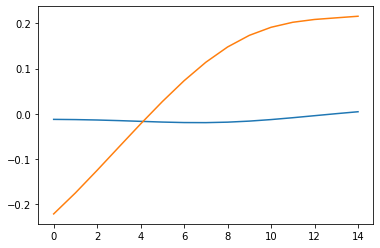

 21%|██        | 21/100 [00:10<00:37,  2.08it/s]

Epoch 20 - Training val loss: 0.044387961737811565


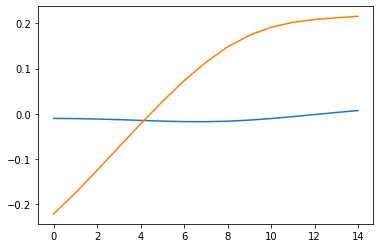

 22%|██▏       | 22/100 [00:10<00:37,  2.09it/s]

Epoch 21 - Training val loss: 0.04433480929583311


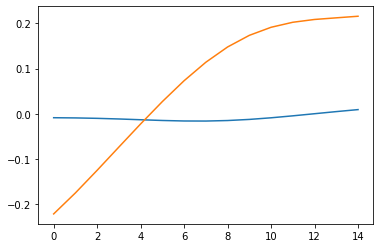

 23%|██▎       | 23/100 [00:11<00:37,  2.07it/s]

Epoch 22 - Training val loss: 0.0442731361836195


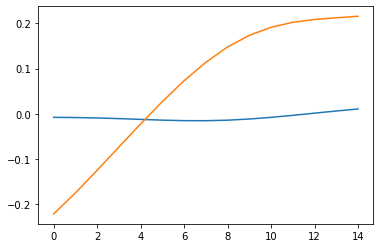

 24%|██▍       | 24/100 [00:11<00:36,  2.06it/s]

Epoch 23 - Training val loss: 0.04419414512813091


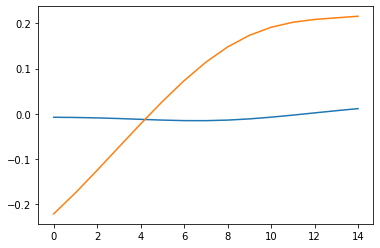

 25%|██▌       | 25/100 [00:12<00:40,  1.86it/s]

Epoch 24 - Training val loss: 0.04409212339669466


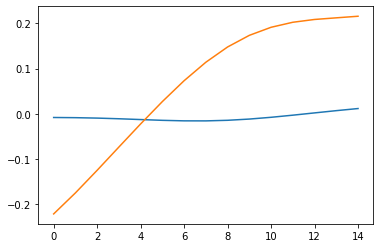

 26%|██▌       | 26/100 [00:12<00:38,  1.94it/s]

Epoch 25 - Training val loss: 0.043964444659650326


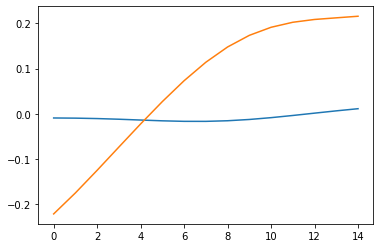

 27%|██▋       | 27/100 [00:13<00:37,  1.96it/s]

Epoch 26 - Training val loss: 0.043811142444610596


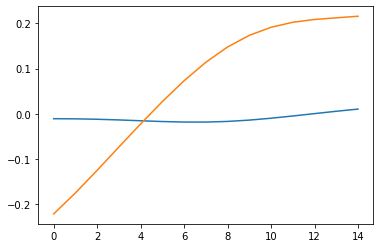

 28%|██▊       | 28/100 [00:13<00:35,  2.01it/s]

Epoch 27 - Training val loss: 0.04363418556749821


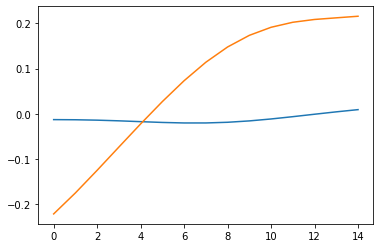

 29%|██▉       | 29/100 [00:14<00:34,  2.04it/s]

Epoch 28 - Training val loss: 0.043436549603939056


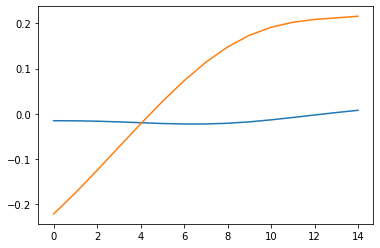

 30%|███       | 30/100 [00:14<00:34,  2.05it/s]

Epoch 29 - Training val loss: 0.04322121478617191


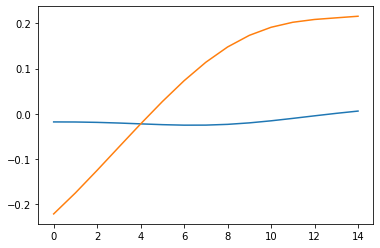

 31%|███       | 31/100 [00:15<00:33,  2.05it/s]

Epoch 30 - Training val loss: 0.04299009498208761


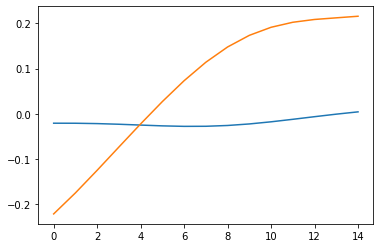

 32%|███▏      | 32/100 [00:15<00:32,  2.07it/s]

Epoch 31 - Training val loss: 0.042742980644106865


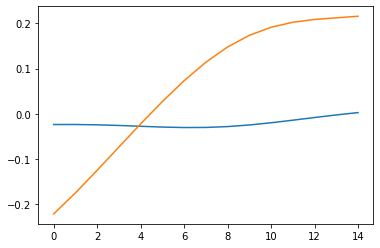

 33%|███▎      | 33/100 [00:16<00:32,  2.03it/s]

Epoch 32 - Training val loss: 0.04247650224715471


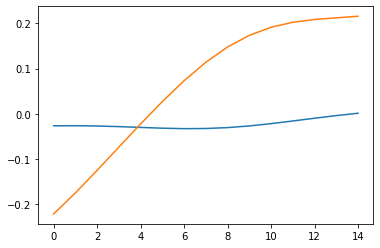

 34%|███▍      | 34/100 [00:16<00:32,  2.05it/s]

Epoch 33 - Training val loss: 0.042183199897408485


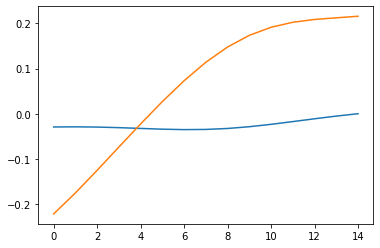

 35%|███▌      | 35/100 [00:17<00:31,  2.06it/s]

Epoch 34 - Training val loss: 0.041850763373076916


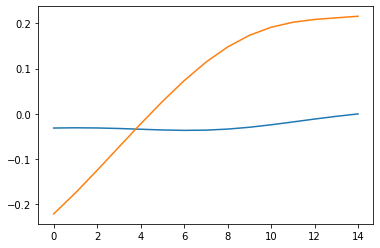

 36%|███▌      | 36/100 [00:17<00:31,  2.06it/s]

Epoch 35 - Training val loss: 0.04146157298237085


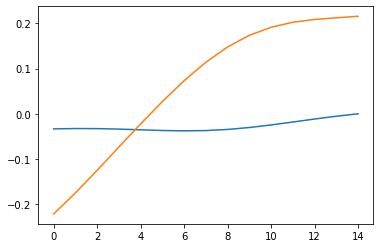

 37%|███▋      | 37/100 [00:18<00:30,  2.07it/s]

Epoch 36 - Training val loss: 0.04099254868924618


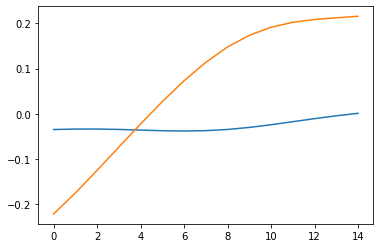

 38%|███▊      | 38/100 [00:18<00:30,  2.07it/s]

Epoch 37 - Training val loss: 0.040414974093437195


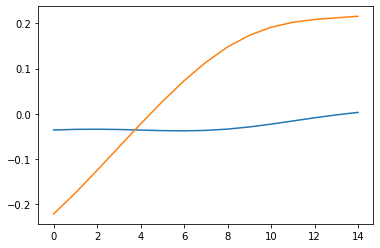

 39%|███▉      | 39/100 [00:19<00:29,  2.06it/s]

Epoch 38 - Training val loss: 0.03969347197562456


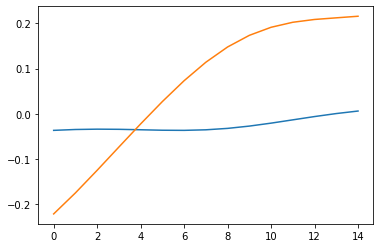

 40%|████      | 40/100 [00:19<00:29,  2.04it/s]

Epoch 39 - Training val loss: 0.03878287971019745


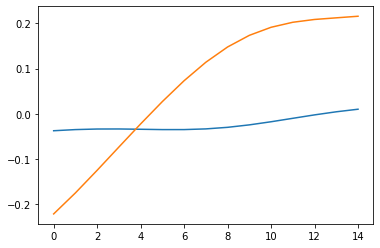

 41%|████      | 41/100 [00:20<00:28,  2.05it/s]

Epoch 40 - Training val loss: 0.03762170020490885


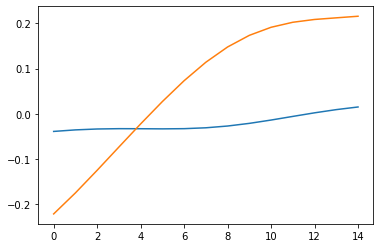

 42%|████▏     | 42/100 [00:20<00:28,  2.04it/s]

Epoch 41 - Training val loss: 0.036120856180787086


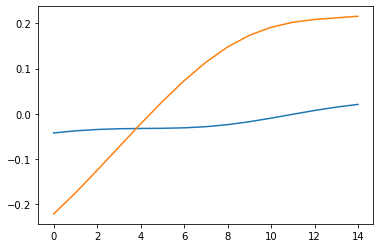

 43%|████▎     | 43/100 [00:21<00:27,  2.05it/s]

Epoch 42 - Training val loss: 0.03414781577885151


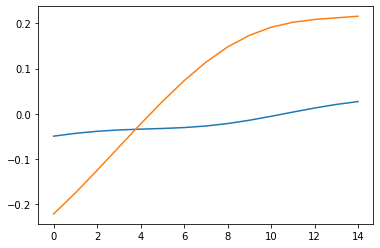

 44%|████▍     | 44/100 [00:21<00:27,  2.04it/s]

Epoch 43 - Training val loss: 0.03151663392782211


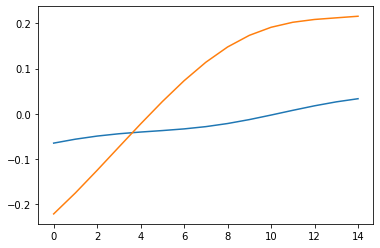

 45%|████▌     | 45/100 [00:22<00:26,  2.04it/s]

Epoch 44 - Training val loss: 0.028054147493094206


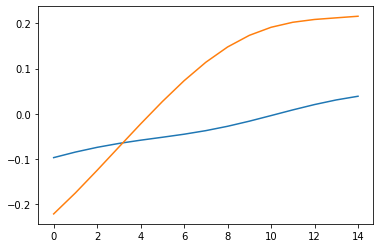

 46%|████▌     | 46/100 [00:22<00:26,  2.05it/s]

Epoch 45 - Training val loss: 0.024130586069077253


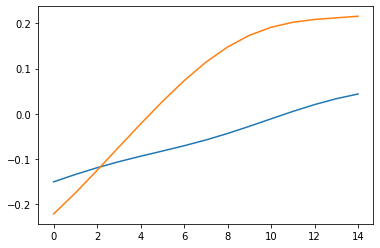

 47%|████▋     | 47/100 [00:23<00:25,  2.06it/s]

Epoch 46 - Training val loss: 0.022552354726940393


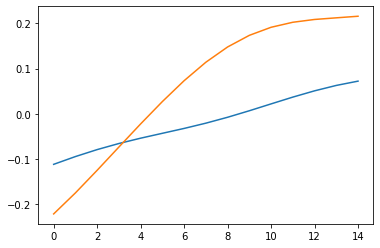

 48%|████▊     | 48/100 [00:23<00:25,  2.06it/s]

Epoch 47 - Training val loss: 0.017537043429911137


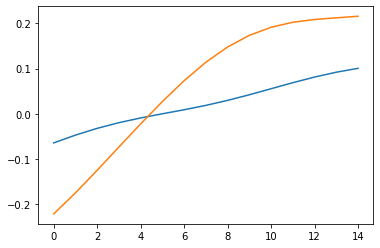

 49%|████▉     | 49/100 [00:23<00:24,  2.06it/s]

Epoch 48 - Training val loss: 0.015034125419333577


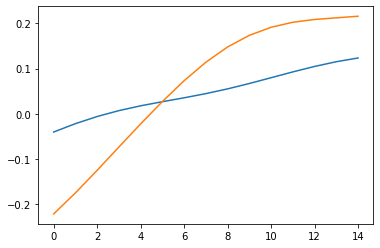

 50%|█████     | 50/100 [00:24<00:24,  2.05it/s]

Epoch 49 - Training val loss: 0.013451870996505022


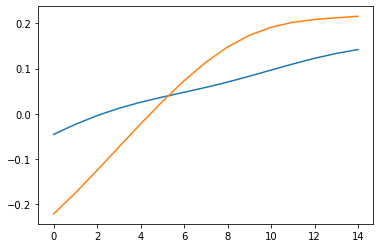

 51%|█████     | 51/100 [00:24<00:23,  2.07it/s]

Epoch 50 - Training val loss: 0.01030282722786069


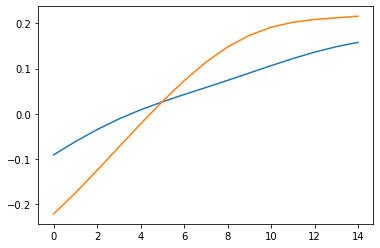

 52%|█████▏    | 52/100 [00:25<00:23,  2.08it/s]

Epoch 51 - Training val loss: 0.008193164598196745


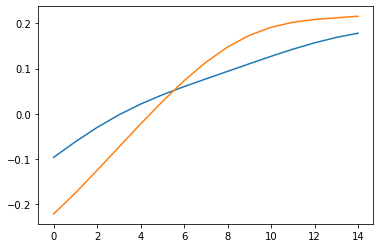

 53%|█████▎    | 53/100 [00:25<00:22,  2.09it/s]

Epoch 52 - Training val loss: 0.007361908443272114


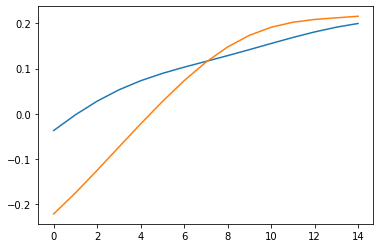

 54%|█████▍    | 54/100 [00:26<00:22,  2.07it/s]

Epoch 53 - Training val loss: 0.005967267090454698


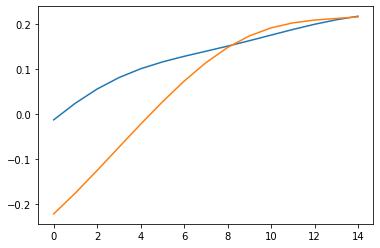

 55%|█████▌    | 55/100 [00:26<00:21,  2.08it/s]

Epoch 54 - Training val loss: 0.006787137594074011


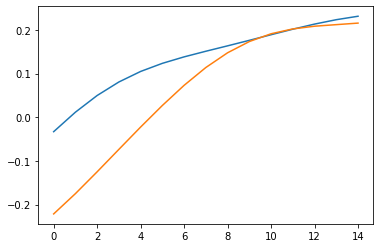

 56%|█████▌    | 56/100 [00:27<00:21,  2.08it/s]

Epoch 55 - Training val loss: 0.006593542522750795


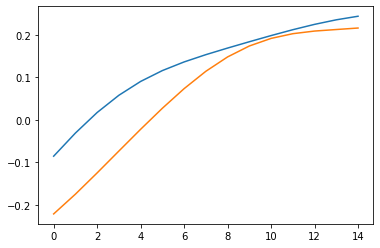

 57%|█████▋    | 57/100 [00:27<00:20,  2.08it/s]

Epoch 56 - Training val loss: 0.00709005887620151


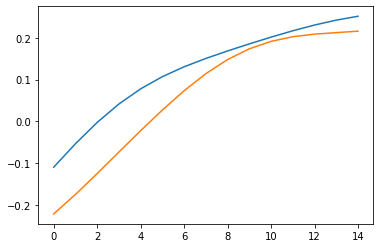

 58%|█████▊    | 58/100 [00:28<00:22,  1.85it/s]

Epoch 57 - Training val loss: 0.006801266339607537


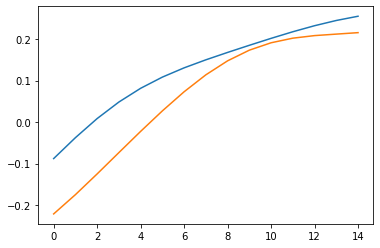

 59%|█████▉    | 59/100 [00:28<00:21,  1.92it/s]

Epoch 58 - Training val loss: 0.005476516322232783


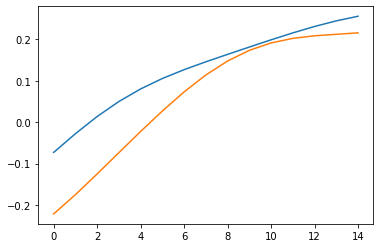

 60%|██████    | 60/100 [00:29<00:20,  1.97it/s]

Epoch 59 - Training val loss: 0.0052184524247422814


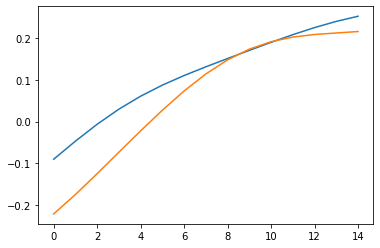

 61%|██████    | 61/100 [00:30<00:20,  1.93it/s]

Epoch 60 - Training val loss: 0.004652492702007294


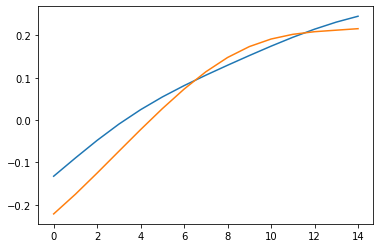

 62%|██████▏   | 62/100 [00:30<00:19,  1.94it/s]

Epoch 61 - Training val loss: 0.003733980527613312


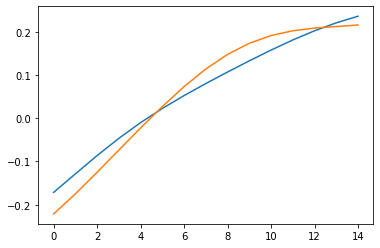

 63%|██████▎   | 63/100 [00:30<00:18,  1.98it/s]

Epoch 62 - Training val loss: 0.0032599084079265594


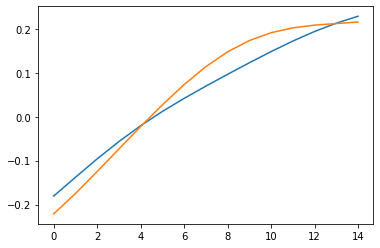

 64%|██████▍   | 64/100 [00:31<00:18,  1.99it/s]

Epoch 63 - Training val loss: 0.0027735400944948196


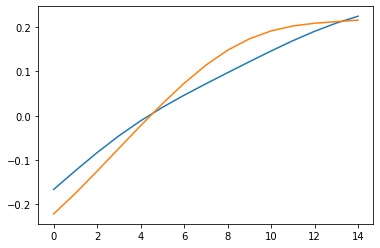

 65%|██████▌   | 65/100 [00:31<00:17,  2.02it/s]

Epoch 64 - Training val loss: 0.0023914616904221475


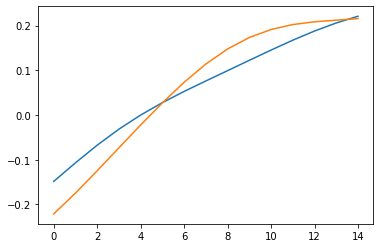

 66%|██████▌   | 66/100 [00:32<00:16,  2.02it/s]

Epoch 65 - Training val loss: 0.0024701901711523533


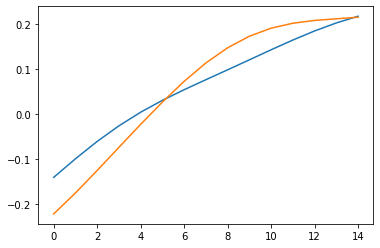

 67%|██████▋   | 67/100 [00:32<00:16,  2.01it/s]

Epoch 66 - Training val loss: 0.0027207028470002115


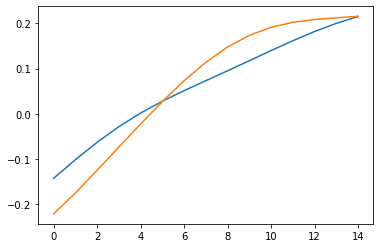

 68%|██████▊   | 68/100 [00:33<00:16,  2.00it/s]

Epoch 67 - Training val loss: 0.0028541652718558908


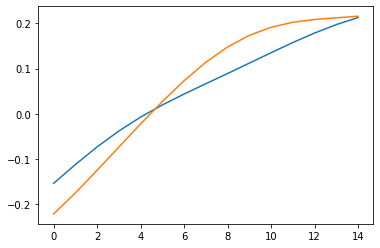

 69%|██████▉   | 69/100 [00:33<00:15,  2.02it/s]

Epoch 68 - Training val loss: 0.002858308027498424


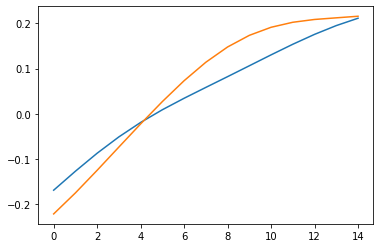

 70%|███████   | 70/100 [00:34<00:14,  2.01it/s]

Epoch 69 - Training val loss: 0.002830421959515661


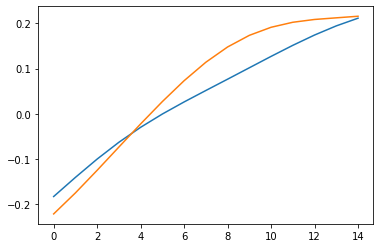

 71%|███████   | 71/100 [00:34<00:14,  1.99it/s]

Epoch 70 - Training val loss: 0.0027898232801817358


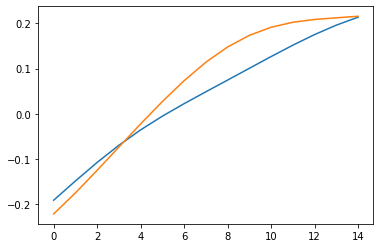

 72%|███████▏  | 72/100 [00:35<00:14,  2.00it/s]

Epoch 71 - Training val loss: 0.002672308648470789


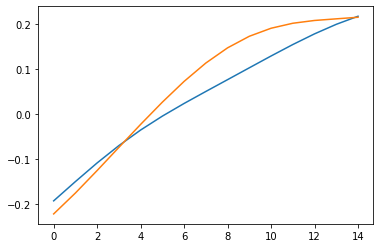

 73%|███████▎  | 73/100 [00:35<00:13,  2.01it/s]

Epoch 72 - Training val loss: 0.0024804503191262484


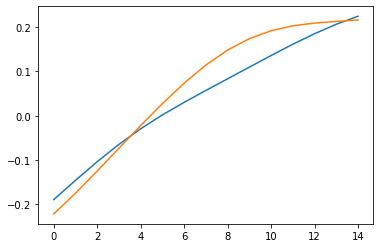

 74%|███████▍  | 74/100 [00:36<00:12,  2.00it/s]

Epoch 73 - Training val loss: 0.002319418534170836


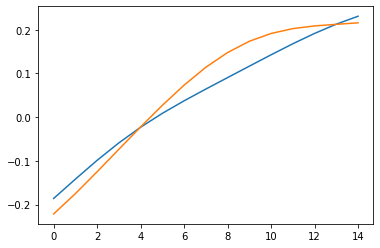

 75%|███████▌  | 75/100 [00:36<00:12,  2.01it/s]

Epoch 74 - Training val loss: 0.002258148044347763


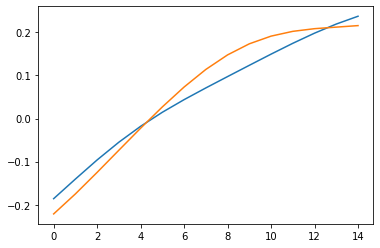

 76%|███████▌  | 76/100 [00:37<00:11,  2.01it/s]

Epoch 75 - Training val loss: 0.0022672543418593705


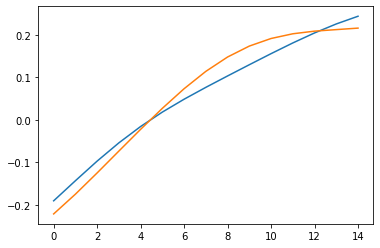

 77%|███████▋  | 77/100 [00:37<00:11,  2.00it/s]

Epoch 76 - Training val loss: 0.002297635597642511


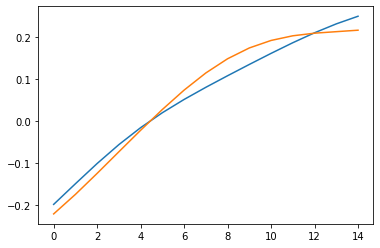

 78%|███████▊  | 78/100 [00:38<00:11,  1.98it/s]

Epoch 77 - Training val loss: 0.002343369764275849


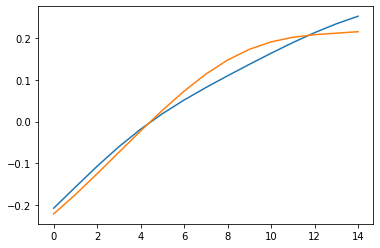

 79%|███████▉  | 79/100 [00:38<00:10,  2.00it/s]

Epoch 78 - Training val loss: 0.002408766944427043


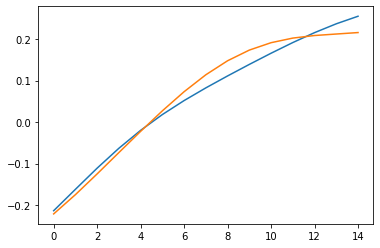

 80%|████████  | 80/100 [00:39<00:09,  2.01it/s]

Epoch 79 - Training val loss: 0.002455007459502667


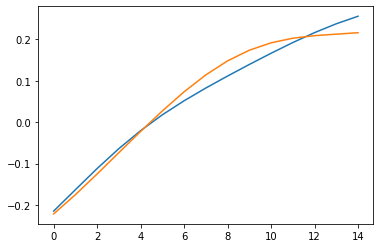

 81%|████████  | 81/100 [00:39<00:09,  2.00it/s]

Epoch 80 - Training val loss: 0.002428857609629631


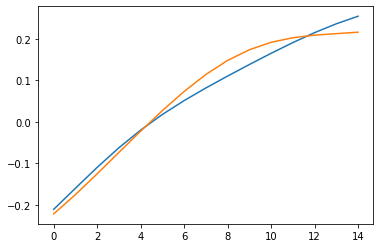

 82%|████████▏ | 82/100 [00:40<00:09,  1.99it/s]

Epoch 81 - Training val loss: 0.0023361900239251554


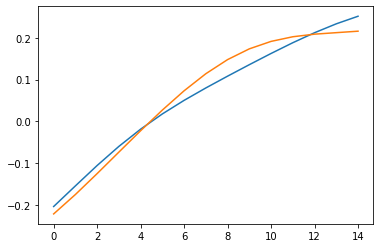

 83%|████████▎ | 83/100 [00:40<00:08,  2.02it/s]

Epoch 82 - Training val loss: 0.0022380113368853927


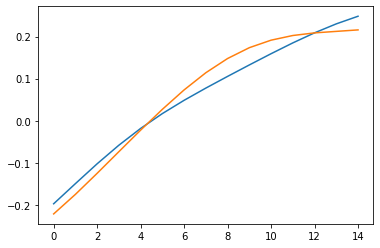

 84%|████████▍ | 84/100 [00:41<00:07,  2.03it/s]

Epoch 83 - Training val loss: 0.0021797819063067436


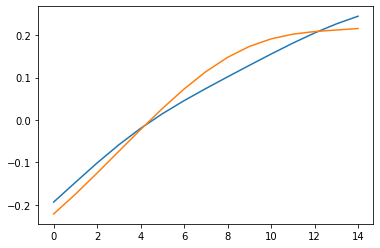

 85%|████████▌ | 85/100 [00:41<00:07,  2.03it/s]

Epoch 84 - Training val loss: 0.002160588395781815


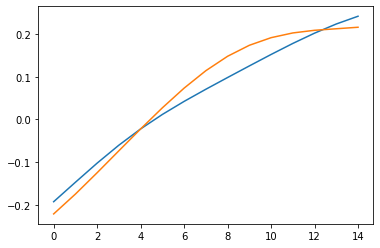

 86%|████████▌ | 86/100 [00:42<00:06,  2.02it/s]

Epoch 85 - Training val loss: 0.0021611531265079975


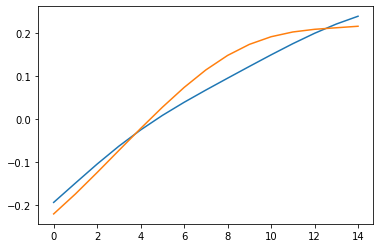

 87%|████████▋ | 87/100 [00:42<00:06,  2.03it/s]

Epoch 86 - Training val loss: 0.00217140419408679


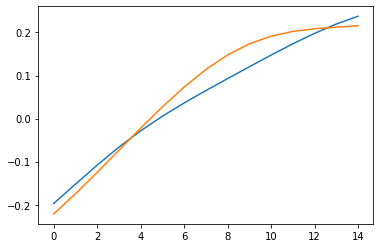

 88%|████████▊ | 88/100 [00:43<00:05,  2.02it/s]

Epoch 87 - Training val loss: 0.0021869437769055367


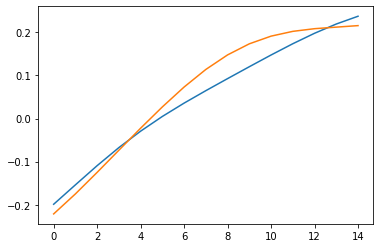

 89%|████████▉ | 89/100 [00:43<00:05,  2.02it/s]

Epoch 88 - Training val loss: 0.0021966731874272227


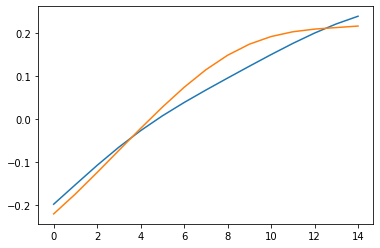

 90%|█████████ | 90/100 [00:44<00:04,  2.02it/s]

Epoch 89 - Training val loss: 0.0021883382578380406


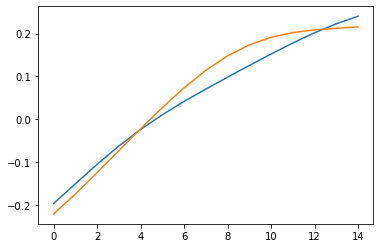

 91%|█████████ | 91/100 [00:45<00:04,  1.83it/s]

Epoch 90 - Training val loss: 0.002162363671232015


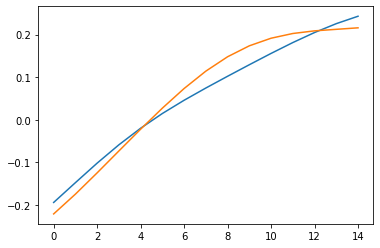

 92%|█████████▏| 92/100 [00:45<00:04,  1.87it/s]

Epoch 91 - Training val loss: 0.0021296447375789285


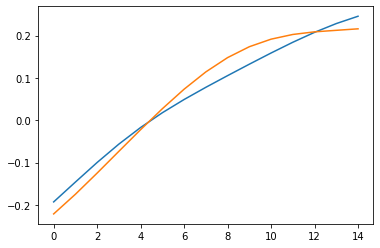

 93%|█████████▎| 93/100 [00:46<00:03,  1.91it/s]

Epoch 92 - Training val loss: 0.002098504570312798


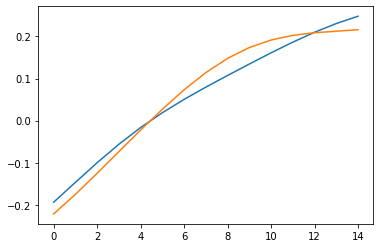

 94%|█████████▍| 94/100 [00:46<00:03,  1.93it/s]

Epoch 93 - Training val loss: 0.0020718073355965316


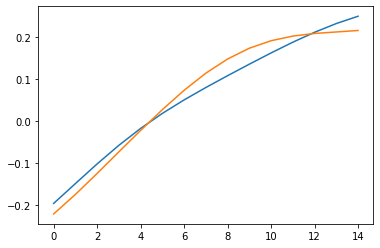

 95%|█████████▌| 95/100 [00:47<00:02,  1.95it/s]

Epoch 94 - Training val loss: 0.0020534684881567955


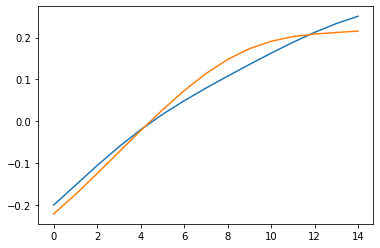

 96%|█████████▌| 96/100 [00:47<00:02,  1.94it/s]

Epoch 95 - Training val loss: 0.0020486045395955443


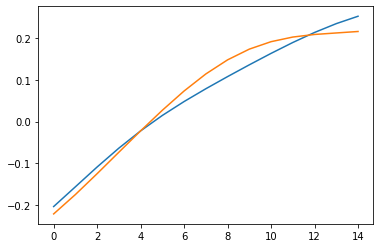

 97%|█████████▋| 97/100 [00:48<00:01,  1.96it/s]

Epoch 96 - Training val loss: 0.0020549283362925053


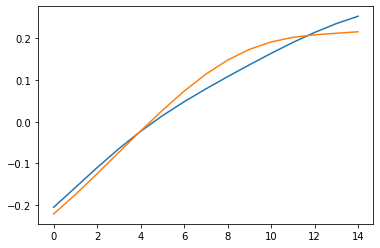

 98%|█████████▊| 98/100 [00:48<00:01,  1.96it/s]

Epoch 97 - Training val loss: 0.0020605578320100904


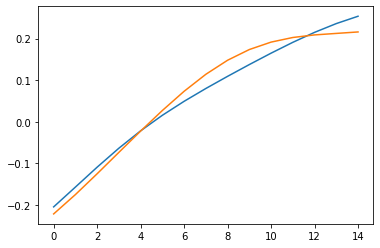

 99%|█████████▉| 99/100 [00:49<00:00,  1.98it/s]

Epoch 98 - Training val loss: 0.002055844583082944


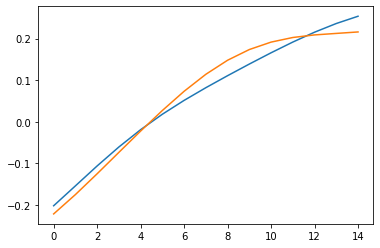

100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

Epoch 99 - Training val loss: 0.002042712294496596


In [ ]:
from tqdm import tqdm
import torch.utils.data as data



model = LSTMModel().cuda()
print("\n\nNombre de paramètres : ", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("\n\n")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

dataset = torch.utils.data.TensorDataset(torch.Tensor(train_X).cuda(), torch.Tensor(train_Y).cuda())
dataset = data.DataLoader(dataset, batch_size=64, shuffle=True)

dataset_valid = torch.utils.data.TensorDataset(torch.Tensor(test_X).cuda(), torch.Tensor(test_Y).cuda())
dataset_valid = data.DataLoader(dataset_valid, batch_size=16, shuffle=False)

train(model, 100, dataset, dataset_valid)